# Microscopy distributions and fold-change.

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import skimage.color
import scipy.ndimage
import pandas as pd
import mwc_induction_utils as mwc
import glob
mwc.set_plotting_style()
sns.set_context('talk')
%matplotlib notebook

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The purpose of this notebook is to generate the plots used for the supplementary figure `microscopy_flowchart.pdf`.

##  Fluorescence histograms

In [3]:
# Define the data directory
mic_data = pd.read_csv('../../data/RBS1027_O2_microscopy_cell_intensities.csv')
mic_data = mic_data[mic_data.date==20161018]
# Choose a subset of IPTG concentrations.
IPTG_range = [0, 10, 75,  250, 5000]

<IPython.core.display.Javascript object>


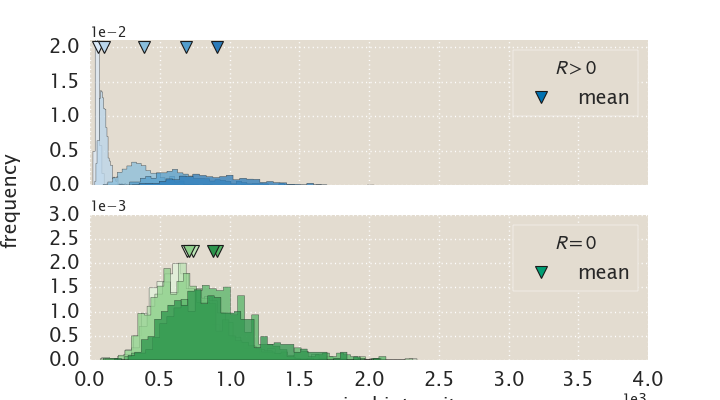

In [4]:
grouped = pd.groupby(mic_data, ['rbs', 'IPTG_uM'])
blues = sns.color_palette('Blues')
greens = sns.color_palette('Greens')
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9,5))
ax[0].plot([],[], 'v', markersize=10, markeredgewidth=1, markerfacecolor='b',
          markeredgecolor='k', label='mean')
ax[1].plot([],[], 'v', markersize=10, markeredgewidth=1, markerfacecolor='g',
          markeredgecolor='k', label='mean')
ax0_leg = ax[0].legend(loc='upper right', title='$R > 0$', fontsize=18)
ax1_leg = ax[1].legend(loc='upper right', title='$R = 0$', fontsize=18)
plt.setp(ax0_leg.get_title(),fontsize=18)
plt.setp(ax1_leg.get_title(),fontsize=18)

bi = 0
gi = 0
for group, data in grouped:
    if group[0] == 'RBS1027':
        if group[1] in IPTG_range:
            ax[0].hist(data.mean_intensity, bins=40, histtype='stepfilled',
                       color=blues[bi], normed=True, alpha=0.75)
            ax[0].plot(np.mean(data.mean_intensity), 0.02, 'v',
                       markeredgecolor='k', markersize=10, markerfacecolor=blues[bi],
                       markeredgewidth=1)
            bi += 1
            
    
    if group[0] == 'delta':
        if group[1] in IPTG_range:
            ax[1].hist(data.mean_intensity, bins=40, histtype='stepfilled',
                      color=greens[gi], normed=True, alpha=0.75)
            ax[1].plot(np.mean(data.mean_intensity), 0.00225, 'v',
                       markeredgecolor='k', markersize=10, markerfacecolor=greens[gi],
                       markeredgewidth=1)
            gi += 1
        
        
ax[0].set_ylim([0, 21E-3])
ax[1].set_ylim([0, 3E-3])
ax[1].set_xlabel('mean pixel intensity', fontsize=18)
fig.text(0.0, 0.5, 'frequency', va='center', rotation='vertical', fontsize=18)

for a in ax:
    a.ticklabel_format(style = 'sci', scilimits=(0, -3))
    a.tick_params(labelsize=18)
    a.set_xlim([0,4E3])

# plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/microscopy_distributions.svg', bbox_inches='tight')

##  Fold-change calculation

In [5]:
grouped = pd.groupby(mic_data, ['IPTG_uM'])
# delta = mic_data[(mic_data.rbs=='delta') & (mic_data.IPTG_uM==0)].mean_intensity.mean()
auto = mic_data[(mic_data.rbs=='auto') & (mic_data.IPTG_uM==0)].mean_intensity.mean()
fc = []
for group, data in grouped:
#     auto = data[data.rbs=='auto'].mean_intensity.mean()
    delta = data[data.rbs=='delta'].mean_intensity.mean()
    samp = data[(data.rbs!='auto') & (data.rbs!='delta')].mean_intensity.mean()
    fc.append((samp - auto) / (delta - auto))

<IPython.core.display.Javascript object>


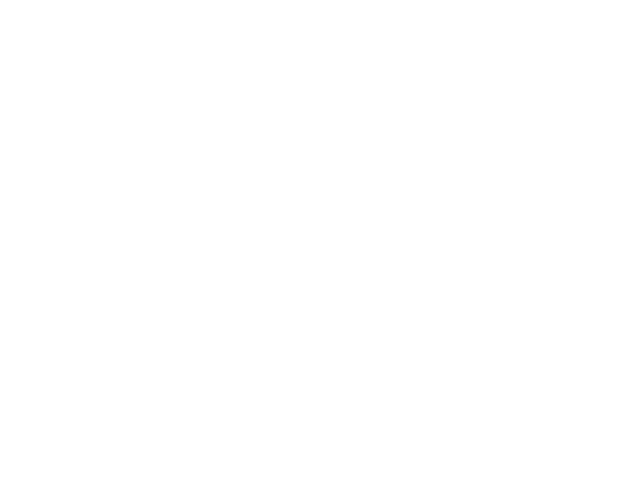

In [6]:
c = np.logspace(-8, -2, 500)
theo_fc = mwc.fold_change_log(c,epsilon=4.5, ea=-np.log(141/1E6), ei=-np.log(0.56/1E6), R=np.array([260]), epsilon_r=-13.9)
IPTG = mic_data.IPTG_uM.unique()/1E6

plt.figure(figsize=(8,6))
plt.plot(c, theo_fc, color='r')
plt.plot(IPTG, fc, 'o', markersize=10, markeredgecolor='r', markerfacecolor='w', markeredgewidth=3)
ax = plt.gca()
plt.text(0.05, 0.9, '$R = 260$', fontsize=24,
        transform=ax.transAxes)
plt.text(0.05, 0.82, r'$\Delta\varepsilon_{RA} = -13.9\,k_BT$', fontsize=24,
        transform=ax.transAxes)
plt.xscale('log')
plt.tick_params(labelsize=20)
plt.xlabel('[IPTG] (M)', fontsize=20)
plt.ylabel('fold-change', fontsize=20)
plt.ylim([0, 1.1])
plt.xlim([1E-8, 1E-2])
plt.tight_layout()


# plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/example_microscopy_titration.svg', bbox_inches='tight')

## Example segmentation. 

Here we will generate an example segmentation applying all area bounds. 

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


<IPython.core.display.Javascript object>


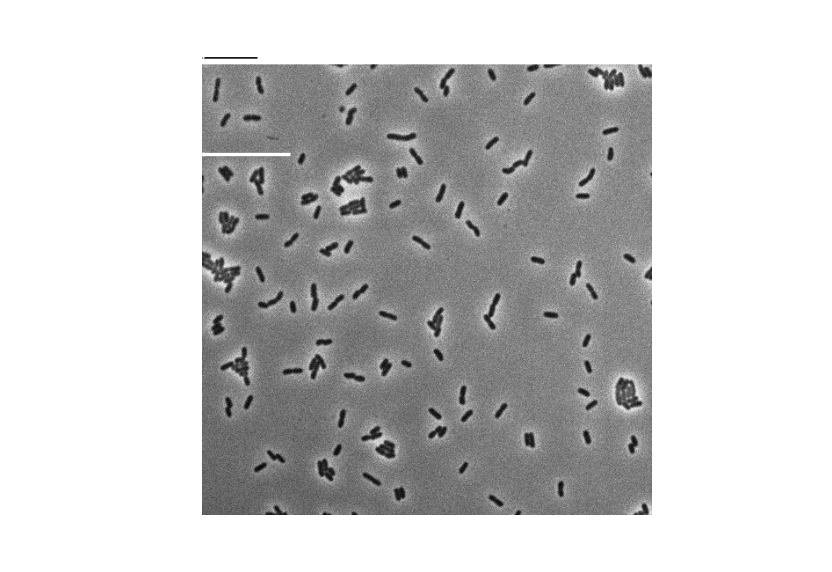

In [55]:
# Load an example image.
ex_im = skimage.io.imread('../../data/microscopy/20161210/20161210_wt_O1_RBS1027_5000uMIPTG_1/20161210_wt_O1_RBS1027_5000uMIPTG_1_MMStack_Pos1.ome.tif')
ph = ex_im[:,:,0]
mch = ex_im[:,:,1]
plt.figure()
plt.imshow(ph, cmap=plt.cm.Greys_r)

/Users/gchure/Lab/PhillipsLab201401-XXX/lab_code/mwc_induction/code/analysis/mwc_induction_utils.py:1244: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if selem == 'default':


<IPython.core.display.Javascript object>


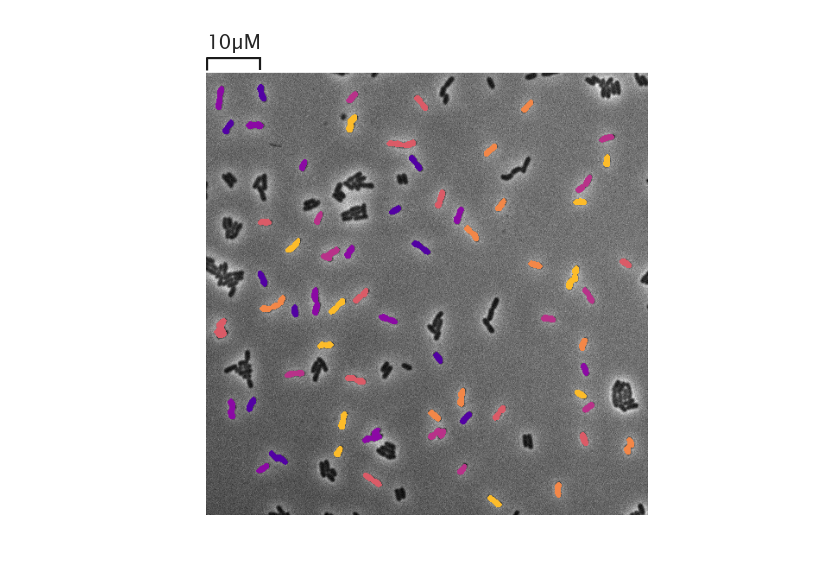

In [92]:
# Perform the segmenatation.
seg = mwc.log_segmentation(mch, label=True)

# Filter by area and eccentricity.
cells = np.zeros_like(seg)
props = skimage.measure.regionprops(seg)

for prop in props:
    area = prop.area * 0.160**2
    ecc = prop.eccentricity
    if (area > 0.5) and (area < 6) and (ecc > 0.8):
        cells += seg==prop.label
        
cells_lab = skimage.measure.label(cells > 0)
colors = sns.color_palette('plasma')
ph_float = (ph - ph.min()) / (ph.max() - ph.min())
rgb_cells = skimage.color.label2rgb(cells_lab, image=ph_float,
                                    alpha=1,bg_label=0, 
                                    colors=colors, bg_color=None)
plt.figure()
plt.imshow(rgb_cells)
plt.grid(False)
ax = plt.gca()
ax.set_frame_on(False)
plt.hlines(-20, 0, 10 / 0.160, color='k', linewidth=3)
plt.vlines(0, -20, -5, color='k', linewidth=3)
plt.vlines(10/0.160, -20, -5, color='k', linewidth=2)
plt.text(0, -30, '10µM', fontsize=18)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/supplementary_figures/example_segmentation_spectral.pdf',
           bbox_inches='tight', dpi=300)

Generate CDFs with the area and eccentricity bounds shaded.

<IPython.core.display.Javascript object>


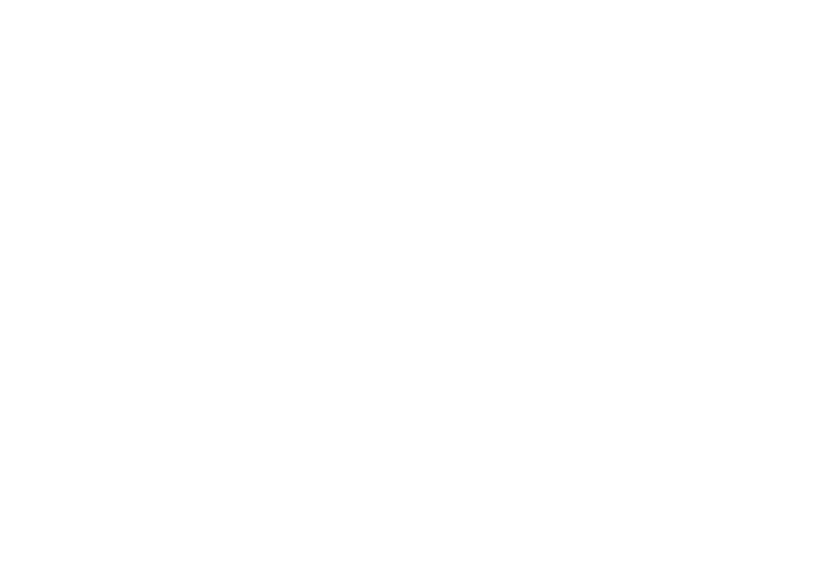

<IPython.core.display.Javascript object>


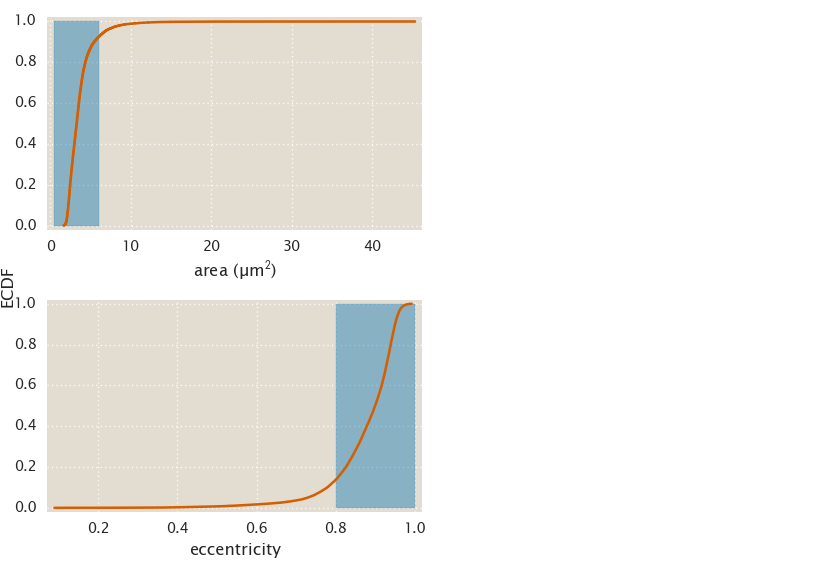

In [148]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax = ax.ravel()
area_x, area_y = mwc.ecdf(mic_data.area)
ecc_x, ecc_y = mwc.ecdf(mic_data.eccentricity)
ax[0].plot(area_x, area_y, 'r-')
ax[0].fill_betweenx(np.linspace(0, 1.0, 500), 0.5, 6, color='b', alpha=0.4)
ax[0].set_xlabel('area (µm$^2$)', fontsize=15)
ax[2].plot(ecc_x, ecc_y, 'r-')
ax[2].fill_betweenx(np.linspace(0, 1.0, 500), 0.8, ax[2].get_xlim()[1], color='b',
                   alpha=0.4)
ax[2].set_xlabel('eccentricity', fontsize=15)
fig.text(0, 0.5, 'ECDF', va='center', rotation='vertical', fontsize=15)

for a in ax:
    a.margins(0.02)
ax[1].set_frame_on(False)    
ax[3].set_frame_on(False)    
ax[1].grid(False)    
ax[3].grid(False) 
ax[1].xaxis.set_ticks([])
ax[3].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[3].yaxis.set_ticks([])
plt.tight_layout()
plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/supplementary_figures/ecdfs_bounds.pdf',
           bbox_inches='tight', dpi=300)

In [129]:
plt.fill_betweenx?

## Display illumination correction

To show that we are properly correcting for the flatfield illumination, we make a figure showing a representative image of the uneven illumination and the flatfield corrected version. 

In [94]:
# Load the images.
field_glob = glob.glob('../../data/microscopy/20161210/*profile*/*.tif')
noise_glob = glob.glob('../../data/microscopy/20161210/*noise*/*.tif')
field_ims = skimage.io.ImageCollection(field_glob)
noise_ims = skimage.io.ImageCollection(noise_glob)
# Generate the averages.
avg_yfp = mwc.average_stack(field_ims)
avg_noise = mwc.average_stack(noise_ims)

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/external/tifffile/tifffile.py:1106: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


<IPython.core.display.Javascript object>


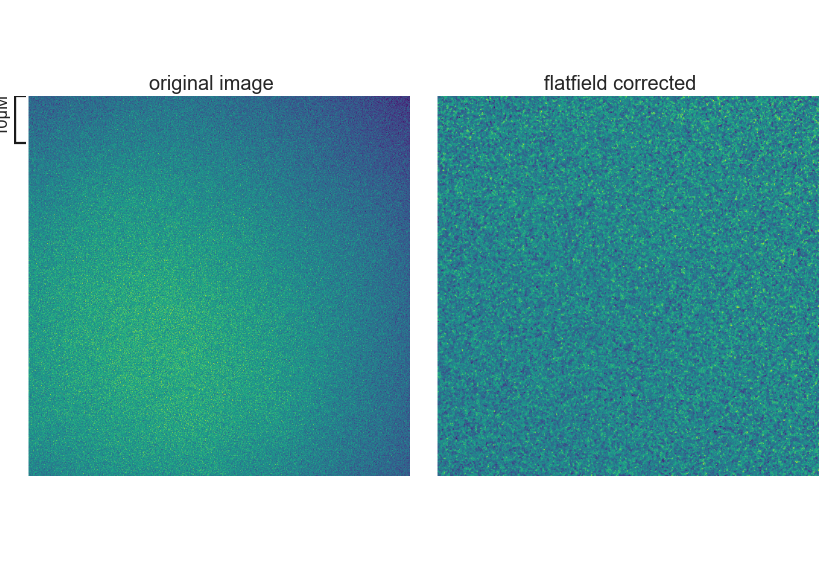

In [114]:
# Correct the illumination on the first image. 
im_flat = mwc.generate_flatfield(field_ims[0], avg_yfp, avg_noise)
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(field_ims[0], cmap=plt.cm.viridis)
    ax[1].imshow(im_flat, cmap=plt.cm.viridis)
    
    ax[0].set_title('original image', fontsize=18)
    ax[1].set_title('flatfield corrected', fontsize=18)
    ax[0].vlines(-20, 0, 10 / 0.160, color='k', linewidth=3)
    ax[0].hlines(0, -20, -5, color='k', linewidth=2)
    ax[0].hlines(10/0.160, -20, -5, color='k', linewidth=2)
    ax[0].text(-47, 12, '10µM', fontsize=15, rotation='vertical')
    ax[1].vlines(-20, 0, 10 / 0.160, color='w', linewidth=3)
    ax[1].hlines(0, -20, -5, color='w', linewidth=2)
    ax[1].hlines(10/0.160, -20, -5, color='w', linewidth=2)
#     ax[1].text(-50, 10, '10µM', fontsize=15, rotation='vertical')
    for a in ax:
        a.set_frame_on(False)
        a.grid(False)
        a.xaxis.set_ticks([])
        a.yaxis.set_ticks([])
    plt.tight_layout()
    
    plt.savefig('/Users/gchure/Dropbox/mwc_induction/Figures/supplementary_figures/flatfield_example.pdf',
               bbox_inches='tight', dpi=300)